## Training MLPs on the Fashion MNIST dataset

In this problem, we will build MLPs on a freely available vision dataset, <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST</a>. This data has been increasingly gaining popularity as the "hello world!" of the ML community. It is simple enough to test new ideas on, and complex enough that our current models still have room for improvement. While you will find several blog-posts on MLPs for this dataset, we encourage you to work through this on your own- this is designed to familiarize you with pytorch and basic neural networks, for your class project and beyond.

Fashion MNIST consists of many 28x28 grayscale images belonging to 10 different classes of clothing. The task is to train a classifier that can predict the clothing class from the image.

In [713]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#### Let's load the data in pytorch!

All PyTorch datasets have a `tranform` argument to apply common transforms to the input data like normalizing, converting to a tensor etc.. Similarly, the `target_transform` argument can be applied to the output data (we will not use it here).

Read about torch datasets and dataloaders <a href="https://pytorch.org/vision/stable/datasets.html">here</a>!

In [714]:
from torchvision import datasets, transforms

save_dir = 'fashionMNIST_data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(180)
]) # Convert the image into a torch tensor.

train_set = datasets.FashionMNIST(save_dir, download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST(save_dir, download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: fashionMNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomRotation(degrees=[-180.0, 180.0], interpolation=nearest, expand=False, fill=0)
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: fashionMNIST_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomRotation(degrees=[-180.0, 180.0], interpolation=nearest, expand=False, fill=0)
           )


Each of these sets comprises of the image `data` and the clasification `targets`. The `targets` take a numerical value from 1-10 indicating which clothing class each image belongs to.

- Print samples of the classes in the train and test datasets.
- Visualize the first image in the training set.
- Printing its classification label.

train classes:
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.4863,
          0.4980, 0.8784, 0.4471, 0.4471, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.4863,
          0.8118, 0.7725, 0.8392, 0.9529, 0.4745, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.4627, 0.8118,
          0.7725, 0.7725, 0.8039, 0.9412, 0.9569, 0.4902, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0118, 0.0000, 0.0000, 0.4510, 0.8235, 0.7647,
          0.7686, 0.8235, 0.8118, 0.7882,

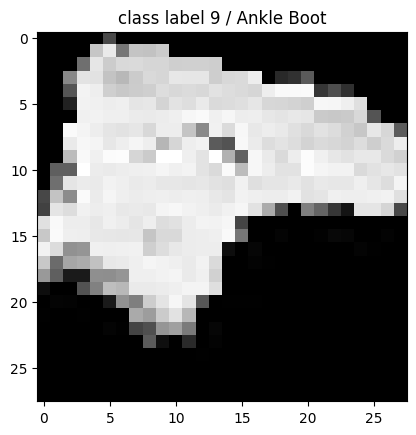

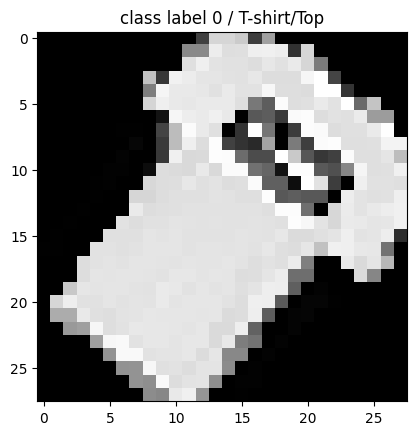

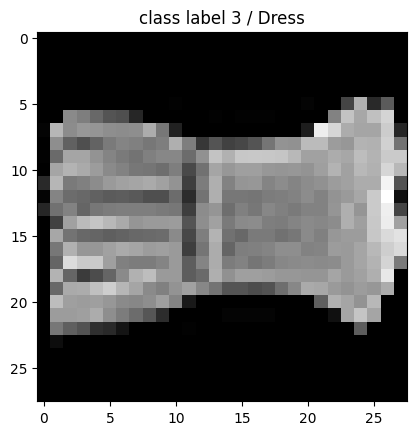

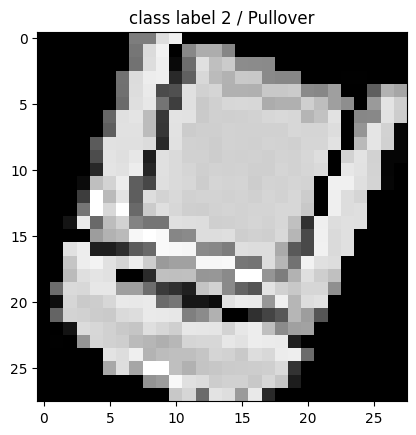

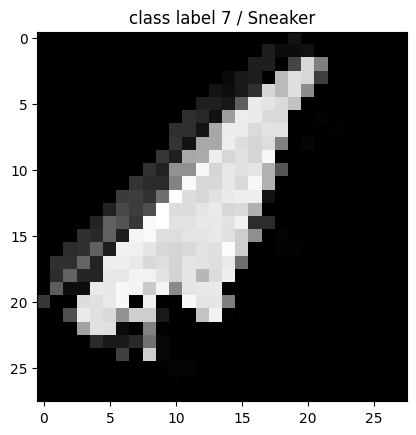

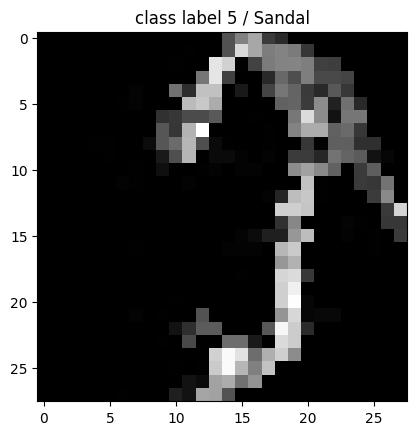

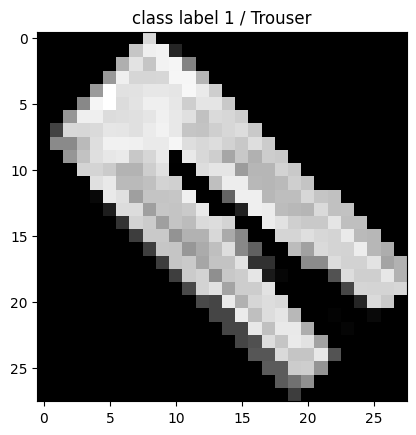

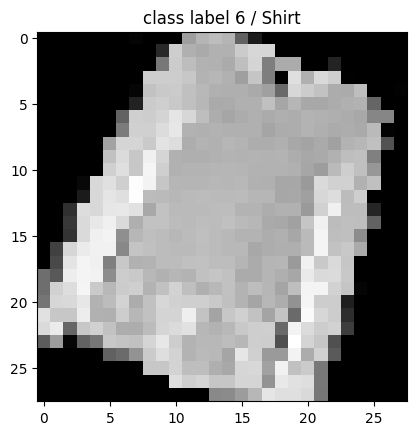

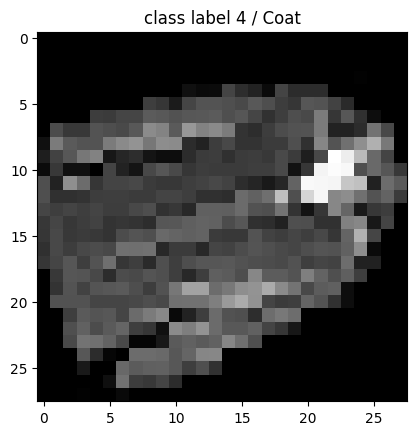

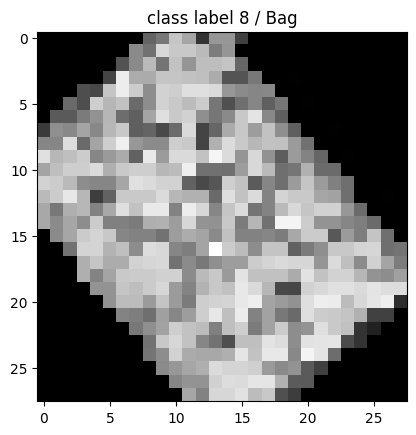

In [715]:
# print classes
train_data_sample = train_set[1]
print("train classes:")
print(train_data_sample, end="... Truncated\n")

test_data_sample = test_set[1]
print("test classes:")
print(test_data_sample, end="... Truncated")

# learning about the shape of image
image, label = train_set[2]

clothing_classes_word = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
clothing_classes_num = [c for c in range(10)]
set_index = 0
while ( len(clothing_classes_num) != 0 ):
    # Get an example image and its label
    image, label = train_set[set_index]
    if label in clothing_classes_num:
        # Convert the image to a NumPy array and display it using matplotlib
        plt.imshow(image.squeeze(), cmap='Greys_r')
        plt.title('class label ' + str(label) + ' / ' + clothing_classes_word[label])
        plt.show()
        clothing_classes_num.remove(label)
    set_index += 1

Since the original data does not have a validation set, let's create one by splitting the training set.

In [716]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.9 * ntotal)
nvalid = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nvalid, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

### Initializing the train, val and test dataloaders with the given `batch_size`

In [717]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

Each loader iterates over the data, yielding `batch_size` images and output targets per iteration.

In [718]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

for images, labels in val_loader:
    print(images.shape, labels.shape)
    break

for images, labels in test_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])


### Initializing an MLP with 3 fully-connected layers. You can add any non-linearity of your choice to the first two layers, and choose the layer widths as well 

In [719]:
class fashionMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1*28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = x.view(-1, 1*28*28)
        y_hat = self.layers(x)
        return y_hat

Tip: An easy way to check if you got the dimensions right is to test your model on a single batch. Iteratively add each layer transformation to the input, and ensure the shape is right at each stage.

In [720]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break
model = fashionMLP()
outputs = model(images)
print(outputs.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 10])


#### Loss and optimizer definitions
### Define `criterion` to be the cross entropy loss function and use an optimizer of your choice in this MLP well use SGD

In [721]:
model_f = fashionMLP()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_f.parameters(), lr=1e-1)

#### Model training and evaluation
### Completing the training, validation and testing loops

In [722]:
from ipywidgets import IntProgress
from IPython.display import display

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        progress_bar = IntProgress(min=0, max=nepoch)
        display(progress_bar)

        for epoch in range(nepoch):
            progress_bar.value = epoch
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += labels.size(0)
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += labels.size(0)
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader, mode):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

### Train the network and report the final test accuracy of your model

In [723]:
train_network(model_f, train_loader, val_loader, criterion, optimizer)
acc, true, pred = test_network(model_f, test_loader, "Model")

IntProgress(value=0)

 Train loss: 0.05079
   Val loss: 0.03617

 Train loss: 0.03891
   Val loss: 0.03630

 Train loss: 0.03614
   Val loss: 0.03624

 Train loss: 0.03656
   Val loss: 0.03616

 Train loss: 0.03612
   Val loss: 0.03624

 Train loss: 0.03657
   Val loss: 0.03619

 Train loss: 0.03614
   Val loss: 0.08601

 Train loss: 0.04263
   Val loss: 0.03624

 Train loss: 0.03612
   Val loss: 0.03615

 Train loss: 0.03613
   Val loss: 0.03613

 Train loss: 0.03611
   Val loss: 0.03616

 Train loss: 0.03613
   Val loss: 0.03622

 Train loss: 0.03615
   Val loss: 0.03618

 Train loss: 0.03612
   Val loss: 0.03620

 Train loss: 0.03612
   Val loss: 0.03619

 Train loss: 0.03613
   Val loss: 0.03615

 Train loss: 0.03614
   Val loss: 0.03619

 Train loss: 0.03613
   Val loss: 0.03626

 Train loss: 0.03613
   Val loss: 0.03624

 Train loss: 0.03613
   Val loss: 0.03627

 Train loss: 0.03612
   Val loss: 0.03629

 Train loss: 0.03613
   Val loss: 0.03637

 Train loss: 0.03686
   Val loss: 0.03632

 Train loss

### Which class did the model get wrong the most? Which class did it get right the most?

In [629]:
class_count = {}
index = 0
while index < len(true):
    if (true[index] == pred[index]):
        if true[index] in class_count:
            class_count [true[index]] += 1
        else:
            class_count [true[index]] = 1
    index += 1

key_with_highest_value = max(class_count, key=class_count.get)
key_with_lowest_value = min(class_count, key=class_count.get)

print(f"Model predicted: {key_with_highest_value} correctly most of the time")
print(f"Model predicted: {key_with_lowest_value} wrong most of the time")


Model predicted: 9 correctly most of the time
Model predicted: 6 wrong most of the time
